In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report
from modeling import optimize, train, evaluate, preprocess
from itertools import product
import seaborn as sns
np.random.seed(42)

In [23]:
df = pd.read_csv('data/processed/clean_and_filled.csv')

`types` is a dataframe containing all features available on the dataset and a respective feature type belonging to one of the following:
- `G` - Genetic/Intrinsic feature (uncontrollable fetures like sex and age)
- `E` - Environmental/Behavioural feature (features that can be controlled, even if slightly, like blood sugar and smoking)
- `H` - Information based on medical history (purely historical information, like previous episodes of chest pain)
- `T` - Test result (tests that require any kind of medical equipment like blood pressure monitors)
- `TP` - Test parameter (condition under which a test has been conducted)
- `CT` - "Cheap" test (tests or checks that can be performed without specific medical equipment)

In [24]:
types = pd.read_csv('data/processed/feature_types.csv').dropna()

In [25]:
for group in types.groupby('feature_type').groups:
    print(types.groupby('feature_type').get_group(group))
    print()

           feature feature_type
3  cp_type_no_pain            ?

               feature feature_type
33  blood_press_s_rest           CT
48     heart_rate_peak           CT
49     heart_rate_rest           CT
53           ex_angina           CT

                feature feature_type
34                 chol            E
35               smoker            E
36  smoker_cigs_per_day            E
37         smoker_years            E
38  fasting_blood_sugar            E

                 feature feature_type
0                  sex_F            G
1                  sex_M            G
29                   age            G
39  heart_disease_family            G

                   feature feature_type
2  cp_type_atypical_angina            H
4      cp_type_non_anginal            H
5   cp_type_typical_angina            H

                               feature feature_type
6                 rest_ecg_hypertrophy            T
7                      rest_ecg_normal            T
8               rest_ec

# Question 2
Do genetic/instrinsic factors play a larger role than environmental/behavioral ones?

In [6]:
model_constructor = RandomForestClassifier

In [7]:
genetic_cols = list(types.groupby('feature_type').get_group('G')['feature']) 
environmental_cols = list(types.groupby('feature_type').get_group('E')['feature']) 

Training models...: 100%|██████████| 120/120 [00:26<00:00,  4.53it/s]


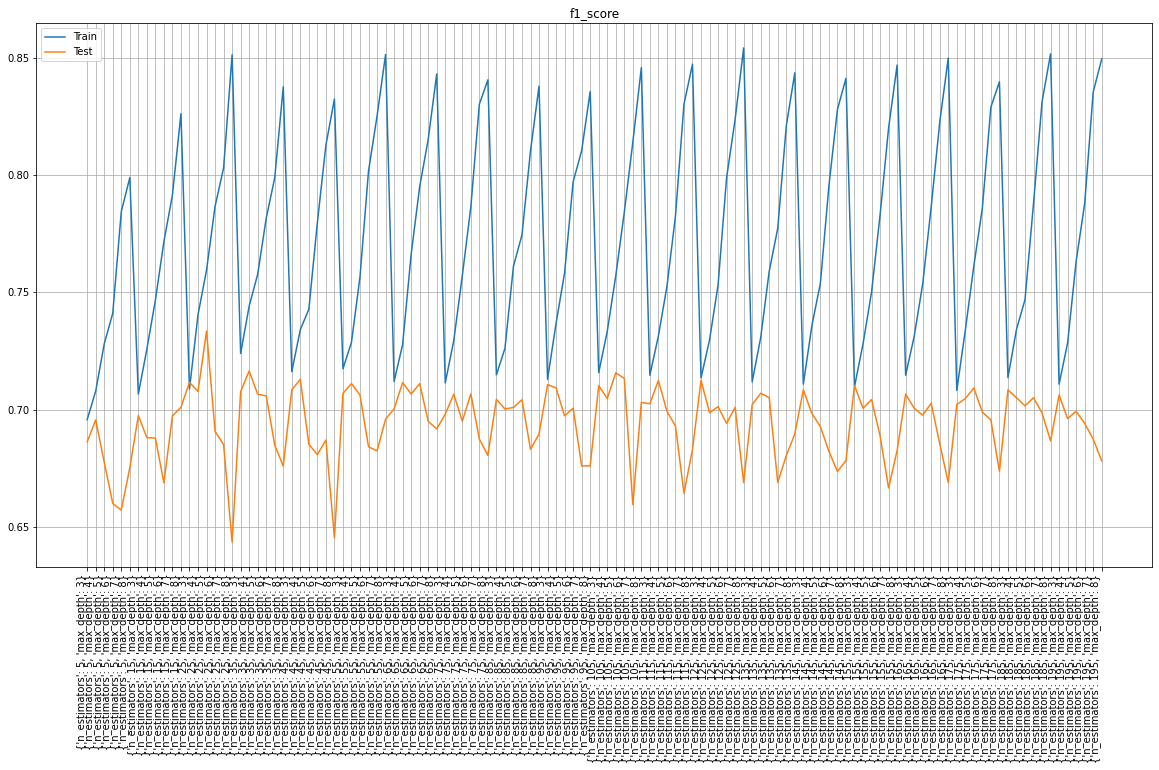

In [8]:
env_params = [{'n_estimators': n, 'max_depth': d} for n, d in product(np.arange(5, 201, 10), np.arange(3, 9))]
env_model, env_training, env_score, env_param = optimize(df[environmental_cols + ['target']], 0.3, model_constructor, env_params, plot=True)

In [9]:
print(environmental_cols)
env_score

['chol', 'smoker', 'smoker_cigs_per_day', 'smoker_years', 'fasting_blood_sugar']


{'f1_score': 0.7335423197492162,
 'accuracy_score': 0.6851851851851852,
 'precision_score': 0.6802325581395349,
 'recall_score': 0.7959183673469388}

Training models...: 100%|██████████| 120/120 [00:26<00:00,  4.57it/s]


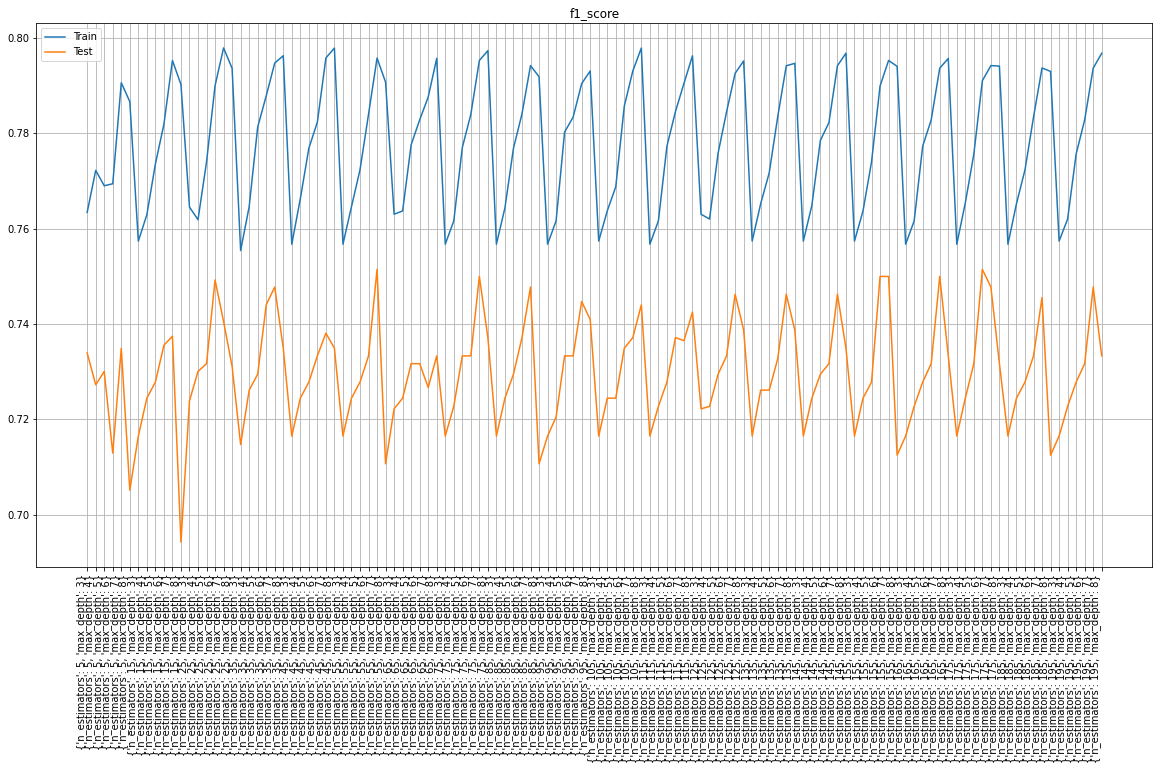

In [10]:
gen_params = [{'n_estimators': n, 'max_depth': d} for n, d in product(np.arange(5, 201, 10), np.arange(3, 9))]
gen_model, gen_training, gen_score, gen_param = optimize(df[genetic_cols + ['target']], 0.3, model_constructor, gen_params, plot=True)

In [11]:
print(genetic_cols)
gen_score

['sex_F', 'sex_M', 'age', 'heart_disease_family']


{'f1_score': 0.7514792899408284,
 'accuracy_score': 0.6888888888888889,
 'precision_score': 0.6649214659685864,
 'recall_score': 0.8639455782312925}

                   genetic  environmental
f1_score         75.147929      73.354232
accuracy_score   68.888889      68.518519
precision_score  66.492147      68.023256
recall_score     86.394558      79.591837


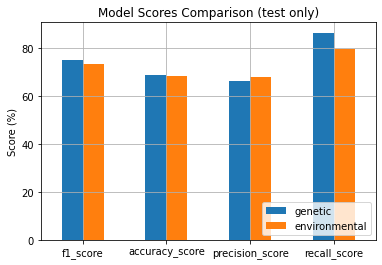

In [12]:
performance_df = pd.DataFrame([gen_score, env_score], index=['genetic', 'environmental']).T
print(performance_df * 100)
(performance_df * 100).plot.bar()
plt.title('Model Scores Comparison (test only)')
plt.xticks(rotation=0)
plt.grid('on')
plt.ylabel('Score (%)')
plt.legend(loc=4)
plt.savefig('data/results/genetic_vs_env_model_scores.png')

# Question 3
Is there a simple or low-cost way to evaluate one's own risk of heart attack?

Training models...: 100%|██████████| 120/120 [00:37<00:00,  3.23it/s]


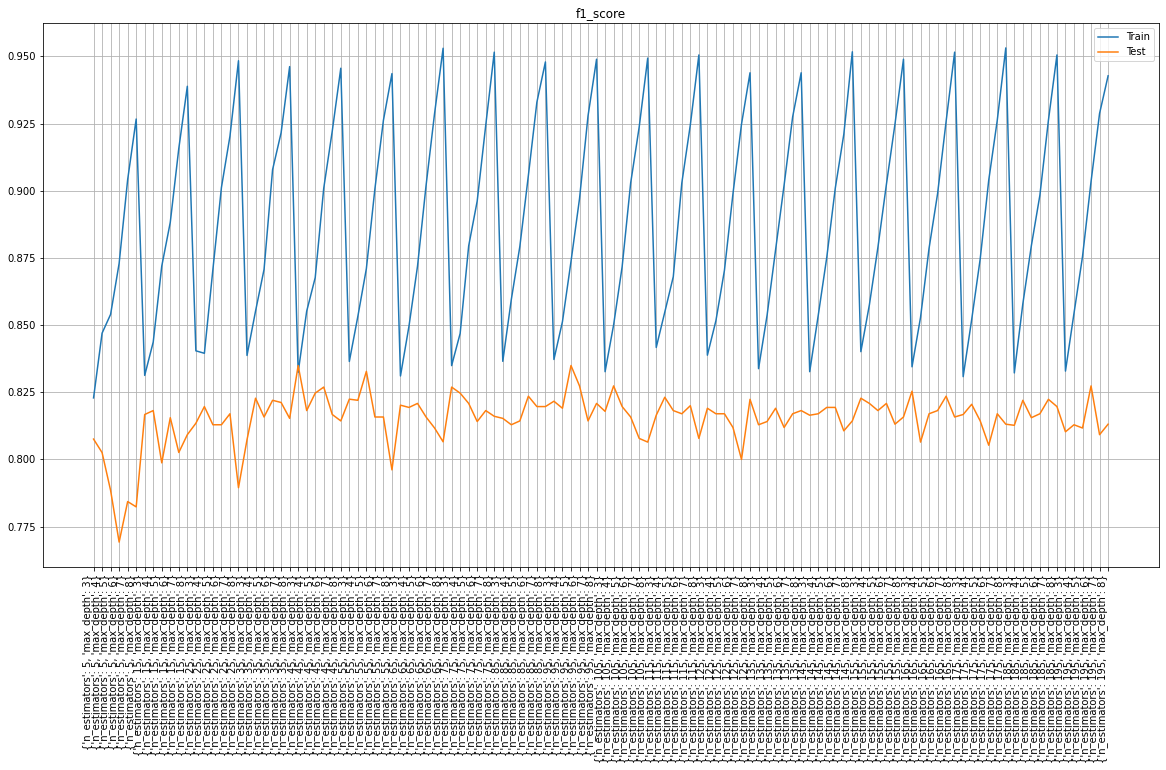

In [13]:
cheap_cols = list(types[types.feature_type.isin(['CT', 'H', 'G', 'E'])].feature)
cheap_params = [{'n_estimators': n, 'max_depth': d} for n, d in product(np.arange(5, 201, 10), np.arange(3, 9))]
cheap_model, cheap_training, cheap_score, cheap_param = optimize(df[cheap_cols + ['target']], 0.3, model_constructor, cheap_params, plot=True)

                   genetic  environmental   low_cost
f1_score         75.147929      73.354232  83.495146
accuracy_score   68.888889      68.518519  81.111111
precision_score  66.492147      68.023256  79.629630
recall_score     86.394558      79.591837  87.755102


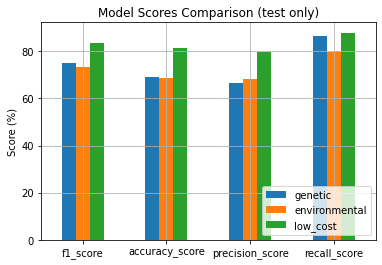

In [14]:
performance_df = pd.DataFrame([gen_score, env_score, cheap_score], index=['genetic', 'environmental', 'low_cost']).T
print(performance_df * 100)
(performance_df * 100).plot.bar()
plt.title('Model Scores Comparison (test only)')
plt.ylabel('Score (%)')
plt.xticks(rotation=0)
plt.grid('on')
plt.legend(loc=4)
plt.savefig('data/results/gen_vs_env_vs_cheap_model_scores.png')

In [26]:
X_train, X_test, y_train, y_test = preprocess(df[cheap_cols + ['target']])
train_scores, test_scores = evaluate(cheap_model, X_train, X_test, y_train, y_test)
test_scores

{'f1_score': 0.8349514563106796,
 'accuracy_score': 0.8111111111111111,
 'precision_score': 0.7962962962962963,
 'recall_score': 0.8775510204081632}

## Comparing to our baseline model
The baseline was trained with all the features

In [16]:
from joblib import load
full_model = load('data/results/gb_full-features_model.joblib')
X_train, X_test, y_train, y_test = preprocess(df)
_, full_score = evaluate(full_model, X_train, X_test, y_train, y_test)
full_score

{'f1_score': 0.8646864686468646,
 'accuracy_score': 0.8481481481481481,
 'precision_score': 0.8397435897435898,
 'recall_score': 0.891156462585034}

                      full   low_cost
f1_score         86.468647  83.495146
accuracy_score   84.814815  81.111111
precision_score  83.974359  79.629630
recall_score     89.115646  87.755102


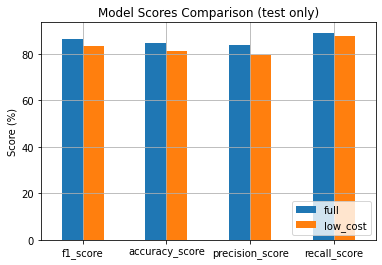

In [30]:
performance_df = pd.DataFrame([full_score, cheap_score], index=['full', 'low_cost']).T
print(performance_df * 100)
(performance_df * 100).plot.bar()
plt.title('Model Scores Comparison (test only)')
plt.ylabel('Score (%)')
plt.xticks(rotation=0)
plt.grid('on')
plt.legend(loc=4)
plt.savefig('data/results/full_vs_low_cost_model_scores.png')

## Bonus! Let's test against the framingham score
*Disclaimer:* Not all the required data for the Framingham score is present in this dataset. As such, the Framingham model will tend to underestimate heart risk in this sample. We're also assuming no blood pressure treatment, as there is no such info on the dataset.

C:\Users\guizi\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Error at threshold 30.0: Classification metrics can't handle a mix of binary and unknown targets
{'f1_score': 0.735632183908046, 'accuracy_score': 0.6592592592592592, 'precision_score': 0.6368159203980099, 'recall_score': 0.8707482993197279}
8.056112224448897


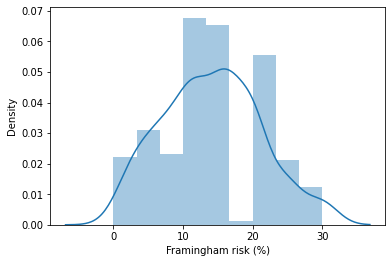

In [88]:
from framingham import FraminghamModel
from sklearn.metrics import confusion_matrix, classification_report, r2_score, f1_score, accuracy_score, precision_score, recall_score

def find_framingham_split():
    fm = FraminghamModel()

    fr_df = pd.read_csv('data/processed/clean_and_filled.csv')
    fr_df.smoker = fr_df.smoker.replace({1: 'yes', 0: 'no'})
    fr_df.sex_M = fr_df.sex_M.replace({1: 'M', 0: 'F'})

    fr_X_test = fr_df.loc[X_test.index].copy()

    fr_results = fr_X_test.apply(fm.predict, axis=1) * 100

    sns.distplot(fr_results)
    plt.xlabel('Framingham risk (%)')
    plt.savefig('data/results/fram_hist.png')
    best_thresh = 0
    best_score = 0
    best_preds = None

    for threshold in np.linspace(fr_results.min(), fr_results.max(), 500):
        fr_preds = (fr_results > threshold).replace({True: 1, False: 0})
        try:
            score = f1_score(y_test, fr_preds)
        except Exception as e:
            print(f'Error at threshold {threshold}: {e}')
        if score > best_score:
            best_thresh = threshold
            best_score = score
            best_preds = fr_preds

    fr_score = {}
    for metric in [f1_score, accuracy_score, precision_score, recall_score]:
        fr_score[metric.__name__] = metric(y_test, best_preds)
    return fr_score, best_thresh

fr_score, best_thresh = find_framingham_split()
print(fr_score)
print(best_thresh)

                 framingham   low_cost
f1_score          73.563218  83.495146
accuracy_score    65.925926  81.111111
precision_score   63.681592  79.629630
recall_score      87.074830  87.755102


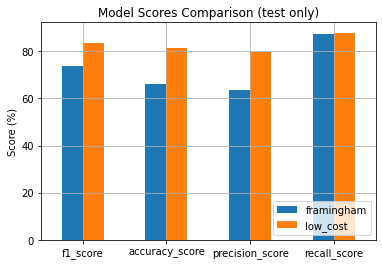

In [87]:
performance_df = pd.DataFrame([fr_score, cheap_score], index=['framingham', 'low_cost']).T
print(performance_df * 100)
(performance_df * 100).plot.bar()
plt.title('Model Scores Comparison (test only)')
plt.ylabel('Score (%)')
plt.xticks(rotation=0)
plt.grid('on')
plt.legend(loc=4)
plt.savefig('data/results/fram_vs_low_cost_model_scores.png')